In [12]:
import warnings, os, sys
warnings.filterwarnings("ignore")
sys.path.append("src")              # allow local imports

import torch
from loguru import logger
from hydra import compose, initialize_config_dir
from omegaconf import DictConfig
from pathlib import Path

In [13]:
# ------------------------------------------------------------------
# 1) Load config
# ------------------------------------------------------------------
config_path = Path.cwd().parent            # folder that contains config.yaml
with initialize_config_dir(config_dir=str(config_path), version_base=None):
    cfg: DictConfig = compose(config_name="config")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.add(cfg.paths.log_dir + "/run.log", rotation="10 MB")

3

In [14]:
# ------------------------------------------------------------------
# 2) Download & engineer features
# ------------------------------------------------------------------

# add the folder one level up so Python can find 'src'
import sys
sys.path.append('..')

from src.data import download_price_news
raw_df = download_price_news(cfg)

# print("RAW DF", raw_df.head())

from src.features import add_indicators
df = add_indicators(raw_df, cfg.features.indicators)

# print(df.head)
print(df.iloc[0])


2025-08-08 20:08:42.273 | INFO     | src.data:_load_from_cache:22 - Loading cached data from c:\Users\niki\Desktop\DeepStocks_AI\version2\.cache\price_data\AAPL_2020-01-01_2025-08-08.csv


Date                2020-02-20
Close                77.628288
High                 78.682561
Low                  77.121754
Open                 78.192994
Volume               100566000
ticker                    AAPL
titles         Analyst upgrade
RSI                  53.041383
MACD                 -0.843615
MACD_Signal          -0.950529
MACD_Hist             0.106914
BB_Upper             80.042921
BB_Middle            77.421349
BB_Lower             74.799777
VWAP                 77.148753
label                        0
Name: 0, dtype: object


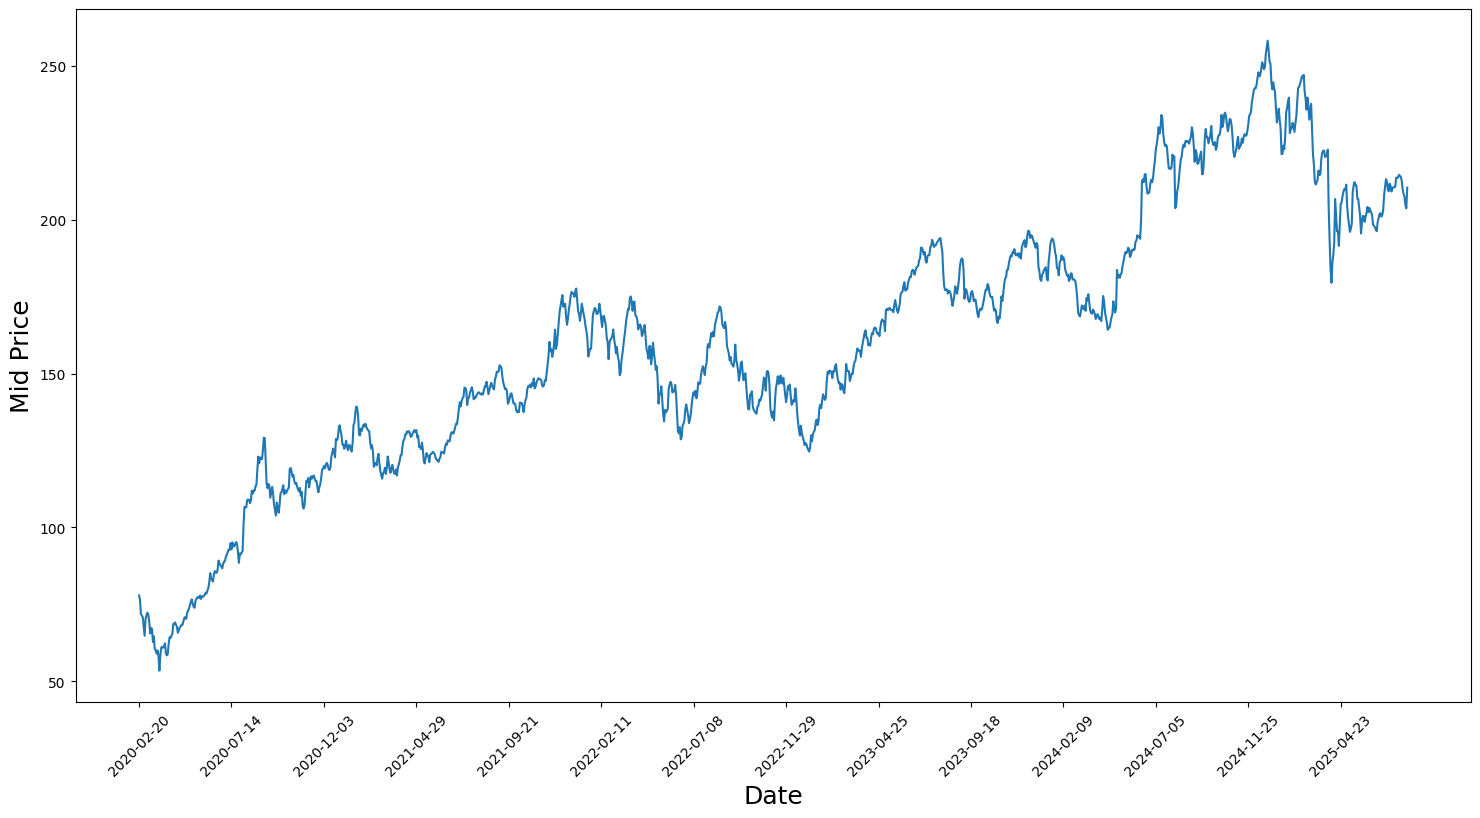

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [16]:
# ------------------------------------------------------------------
# 3) Walk-forward split (purged)
# ------------------------------------------------------------------
from src.data import walk_forward_split
from src.features import build_dataset
train_df, val_df, test_df = walk_forward_split(df, train_pct=0.7,
                                               val_pct=0.15, purge=cfg.features.lookback)

train_ds, val_ds, test_ds, scaler = build_dataset(train_df, val_df, test_df, cfg.features.lookback)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=cfg.training.batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=cfg.training.batch_size)
test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=cfg.training.batch_size)


In [17]:
# ------------------------------------------------------------------
# 4) Model & training
# ------------------------------------------------------------------
from src.model import StockNet, EarlyStopper
from src.train import train_one_epoch, evaluate

num_price_feat = train_ds[0][0].shape[-1]
model = StockNet(num_price_feat).to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=cfg.training.lr,
                             weight_decay=cfg.training.weight_decay)
criterion = torch.nn.CrossEntropyLoss()

Path(cfg.paths.model_dir).mkdir(exist_ok=True, parents=True)
best_path = Path(cfg.paths.model_dir) / "best.pt"
stopper   = EarlyStopper(patience=cfg.training.patience, path=best_path)

for epoch in range(1, cfg.training.max_epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    logger.info(f"Epoch {epoch:03d} | train {tr_acc:.3f} | val {val_acc:.3f}")
    if stopper(val_loss, model):
        logger.info("Early stopping")
        break


2025-08-08 20:09:07.133 | INFO     | __main__:<module>:21 - Epoch 001 | train 0.513 | val 0.575
2025-08-08 20:09:07.473 | INFO     | __main__:<module>:21 - Epoch 002 | train 0.489 | val 0.500
2025-08-08 20:09:07.806 | INFO     | __main__:<module>:21 - Epoch 003 | train 0.528 | val 0.514
2025-08-08 20:09:08.139 | INFO     | __main__:<module>:21 - Epoch 004 | train 0.552 | val 0.452
2025-08-08 20:09:08.473 | INFO     | __main__:<module>:21 - Epoch 005 | train 0.543 | val 0.445
2025-08-08 20:09:08.800 | INFO     | __main__:<module>:21 - Epoch 006 | train 0.532 | val 0.452
2025-08-08 20:09:09.090 | INFO     | __main__:<module>:21 - Epoch 007 | train 0.526 | val 0.479
2025-08-08 20:09:09.406 | INFO     | __main__:<module>:21 - Epoch 008 | train 0.549 | val 0.500
2025-08-08 20:09:09.739 | INFO     | __main__:<module>:21 - Epoch 009 | train 0.528 | val 0.541
2025-08-08 20:09:10.056 | INFO     | __main__:<module>:21 - Epoch 010 | train 0.538 | val 0.466
2025-08-08 20:09:10.366 | INFO     | __m

In [18]:
# ------------------------------------------------------------------
# 5) Test evaluation
# ------------------------------------------------------------------
model.load_state_dict(torch.load(best_path))
test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion, device)
logger.success(f"Test accuracy: {test_acc:.3%}")


2025-08-08 20:11:53.183 | SUCCESS  | __main__:<module>:6 - Test accuracy: 54.545%


In [7]:
# ------------------------------------------------------------------
# 6) Quick inference demo
# ------------------------------------------------------------------
from src.predict import StockPredictor
predictor = StockPredictor(best_path, scaler, cfg.features.lookback)

tail = df.tail(cfg.features.lookback + 1).iloc[:-1]
direction, prob = predictor.predict_one(tail, news="Fed cuts rates")
print(f"Prediction: {direction} @ {prob:.2%}")

Prediction: UP @ 52.80%


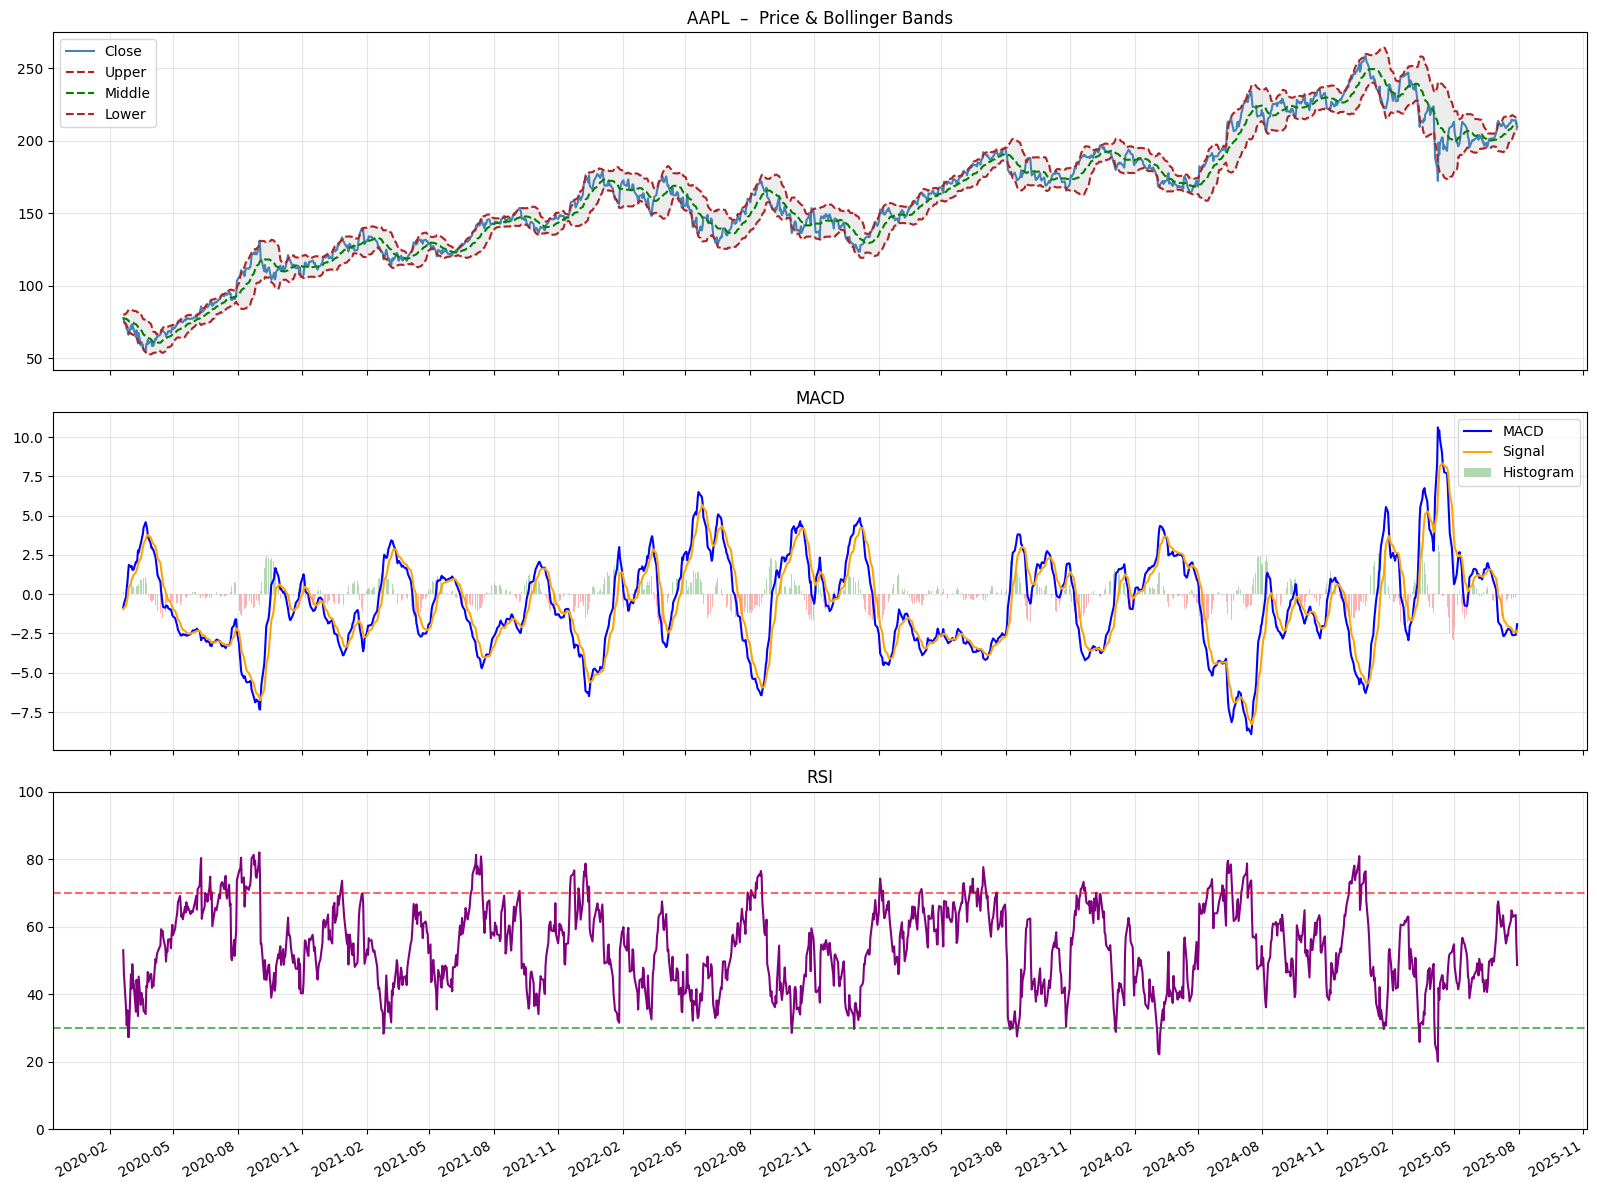

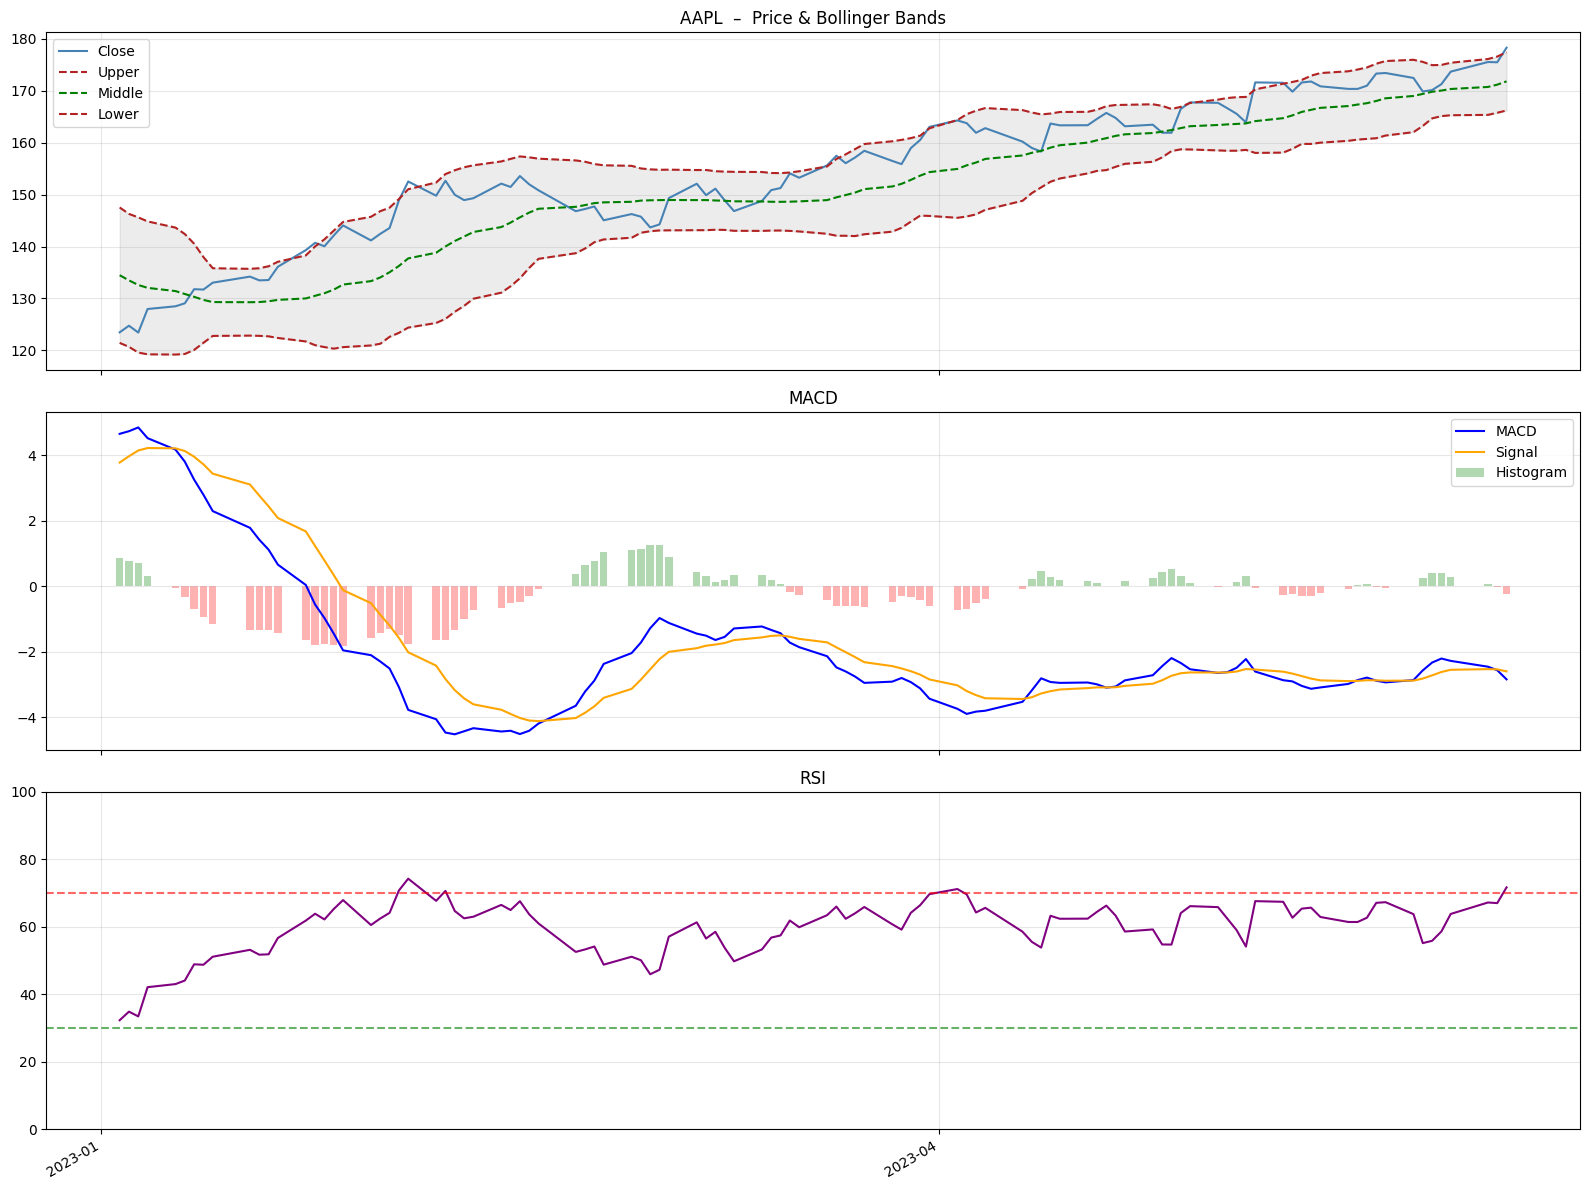

In [8]:
# %%  Plotting utilities (improved)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pathlib import Path

def plot_technical_indicators(df: pd.DataFrame,
                              ticker: str = "AAPL",
                              start_date: str | None = None,
                              end_date: str | None = None,
                              save_path: str | Path | None = None):
    """
    Plot price + technical indicators with proper date formatting.
    Parameters
    ----------
    df : DataFrame with OHLCV + indicator columns
    ticker : str for title
    start_date, end_date : optional date strings to zoom
    save_path : optional file path to save PNG
    """
    plot_df = df.copy()
    plot_df["Date"] = pd.to_datetime(plot_df["Date"])
    plot_df = plot_df.set_index("Date")
    if start_date and end_date:
        plot_df = plot_df.loc[start_date:end_date]

    fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

    # 1) Price + Bollinger Bands
    ax = axes[0]
    ax.plot(plot_df["Close"], label="Close", color="steelblue")
    ax.plot(plot_df["BB_Upper"], label="Upper", color="firebrick", ls="--")
    ax.plot(plot_df["BB_Middle"], label="Middle", color="green", ls="--")
    ax.plot(plot_df["BB_Lower"], label="Lower", color="firebrick", ls="--")
    ax.fill_between(plot_df.index,
                    plot_df["BB_Lower"], plot_df["BB_Upper"],
                    color="grey", alpha=0.15)
    ax.set_title(f"{ticker}  –  Price & Bollinger Bands")
    ax.legend()
    ax.grid(alpha=0.3)

    # 2) MACD
    ax = axes[1]
    ax.plot(plot_df["MACD"], label="MACD", color="blue")
    ax.plot(plot_df["MACD_Signal"], label="Signal", color="orange")
    colors = ["green" if v >= 0 else "red" for v in plot_df["MACD_Hist"]]
    ax.bar(plot_df.index, plot_df["MACD_Hist"].fillna(0),
           color=colors, alpha=0.3, label="Histogram")
    ax.set_title("MACD")
    ax.legend()
    ax.grid(alpha=0.3)

    # 3) RSI
    ax = axes[2]
    ax.plot(plot_df["RSI"], color="purple")
    ax.axhline(70, color="red", ls="--", alpha=0.6)
    ax.axhline(30, color="green", ls="--", alpha=0.6)
    ax.set_ylim(0, 100)
    ax.set_title("RSI")
    ax.grid(alpha=0.3)

    # x-axis formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    fig.autofmt_xdate()
    fig.tight_layout()

    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# ------------------------------------------------------------------
# 1) Plot the entire AAPL dataset
plot_technical_indicators(df, ticker=cfg.data.ticker,
                          save_path="plots/aapl_full.png")

# 2) Zoom into a specific period
plot_technical_indicators(df, ticker=cfg.data.ticker,
                          start_date="2023-01-01",
                          end_date="2023-06-01",
                          save_path="plots/aapl_2023H1.png")